# Abstract

This is a "quick look" test report that determines the capacity of batteries under repetitive charge and discharge cycles (CC/CV). This report reads the test files from the Data folder and performs some EDA on the data. 

In [14]:
# Bring in the needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import re

## Data Cleaning Routine

The files need to be cleaned prior to analyzing. The following routine cleans up the files. The cleanup actions are routine:

* The data was grabbed for me by another engineer. 
* In general, the files contain multiple charge/discharge cycles. I have selected the third cycle (c == 3). I could average the cycles, but they are generally so similar that it is not worth it.
* Each charge/discharge cycle contains multiple stages. Stage 4 is the discharge cycle.

For a reason unknown to me, the CV=4.15V data had a different output format. So I wrote two different cleaning routine. I distinguished the files by call the CV=4.15 data "csv" and the others "txt".


### Clean CSV Files

While I call these CSV files, they actually are tab separated just like the other files. I gave them this name so that I could distinguish their format from the others. I wish I knew why the format was different, but it was. The key format difference is that the step time is in minutes rather than encoded in a string.

In [15]:
def batTweak1(file):
    return (
        pd.read_csv(file, sep="\t",skiprows=4, header=0,usecols=["Cyc#","Step","StepTime","Amps","Volts"])
        .rename({"Volts":"v","Cyc#":"c","StepTime":"t"}, axis=1)
        .query("c == 2 &  Step==4")
        .drop(["Step","Amps","c"],axis=1)
        .assign(q = lambda x: x.t*0.5/60,
                t = lambda x: x.t/60)
    )

### Clean TXT Files

These are tab separated files that have step time encoded as an odd-ball date/time string.

In [25]:
def batTweak(file):
    return (
        pd.read_csv(file, sep="\t",skiprows=5, header=0,usecols=["Cyc#","Step","StepTime","Amps","Volts"])
        .rename({"Volts":"v","Cyc#":"c"}, axis=1)
        .assign(days = lambda x: x.StepTime.str.extract("(.+?)d"),
                hours= lambda x: x.StepTime.str.extract("(?<=d)(.*)"))
        .assign(h =    lambda x: x.hours.str.extract("(\d*)(?=:)"),
                m =    lambda x: x.hours.str.extract("(?<=:)(\d*)"),
                s =    lambda x: x.hours.str.extract("(?<=:\d\d:)(.*)"))
        .drop(["hours","StepTime","hours"],axis=1)
        .astype({"days":"float64","h":"float64","m":"float64","s":"float64"})
        .assign(t = lambda x: x.days*1440+x.h*60+x.m+x.s/60)
        .drop(["h","m","s","days"],axis=1)
        .query("c == 2 &  Step==5")
        .drop(["Step","Amps","c"],axis=1)
        .assign(q = lambda x: x.t*0.5/60,
                t = lambda x: x.t/60)
    )

## Read the TXT Files and Clean

Here we iterate through all the TXT files.

In [26]:
### Utility File Reader

def file_getter(f,g):
    z = pd.DataFrame() # Create an empty dataframe
    for f in files:
        df = g(f)
        unit = re.search("(?<=_U)\w{2}",f).group(0)
        model = re.search("(?<=_M)\w{4}",f).group(0)
        fctr = re.search("(?<=_D)\w{3}",f).group(0)
        df = df.assign(Unit = "U"+unit,
                       Model= model,
                       CV = fctr)
        vc = int(fctr)/100
        new_row = pd.DataFrame({'v':vc, 't':0, 'q':0,'Unit':'U'+unit,"Model":model,"CV":fctr}, index=[0])
        df=pd.concat([new_row,df.loc[:]]).reset_index(drop=True)
        z = z.append(df)
    return z.reset_index(drop=True)
    

In [27]:
files=glob.glob("./Z02_Test/*.txt",recursive=False)
z=file_getter(files,batTweak)
files=glob.glob("./Z02_Test/*.csv",recursive=False)
z1=file_getter(files,batTweak1)
z  = (z.append(z1)
      .sort_values(by=['CV'])
      .reset_index(drop=True)
     )

C:\Users\Mark\AppData\Local\Temp\ipykernel_200\661276572.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  z = z.append(df)
C:\Users\Mark\AppData\Local\Temp\ipykernel_200\661276572.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  z = z.append(df)
C:\Users\Mark\AppData\Local\Temp\ipykernel_200\661276572.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  z = z.append(df)
C:\Users\Mark\AppData\Local\Temp\ipykernel_200\661276572.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  z = z.append(df)
C:\Users\Mark\AppData\Local\Temp\ipykernel_200\670559623.py:5: FutureWarning: The frame.append method is deprecated and will be removed 

# Extract-Transform-Load

Once cleaned, the data is in the correct format but needs to be augmented with information on the unit-under-test (UUT) and battery model info. This data can be extracted from the file name, which has the following format.
<pre><code>
 (tester initials: 2 char)_U(unit number: 2 char)_M(model: 4 characters)_D(test description:any length, spaces=dashes)
</code></pre>
I do not like spaces in file names and I decided that topics are separated by underscores and spaces replaced with dashes. I can illustrate this format as follows:
<pre><code>
MB_U02_MZ22A_DLong-Test-4-1-CV-CH17.txt
</code></pre>

The file information tells us that:

* Tester initials: MB
* Unit Under Test: 02
* Model Under Test: Z22A
* Test Description: Long Test 4.1 CV Channel 17

# Exploratory Data Analysis

The capacity value and the State of Charge (SoC) curve are all derived from the discharge curve, which is what the Maccor battery tester measures. The discharge curve for all the parts is shown below.

In [28]:
z.head()

,v,t,q,Unit,Model,CV
0,4.20000,0.000000,0.000000,U01,Z020,420
1,3.75540,14.016678,7.008339,U03,Z020,420
2,3.75578,14.000011,7.000006,U03,Z020,420
3,3.75601,13.983344,6.991672,U03,Z020,420
4,3.75631,13.966678,6.983339,U03,Z020,420


C:\Users\Mark\AppData\Local\Temp\ipykernel_200\3522105184.py:3: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  fig = sns.lineplot(


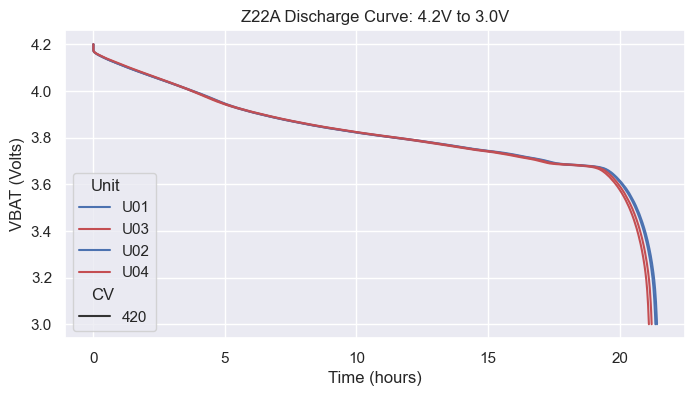

In [29]:
zz = z.groupby("Unit")
sns.set_style("darkgrid")
fig = sns.lineplot(
            x='t', 
            y='v',
            hue='Unit',
            style="CV",
            palette=['b','r'],
            data=z)
plt.xlabel("Time (hours)")
plt.ylabel("VBAT (Volts)")
plt.title("Z22A Discharge Curve: 4.2V to 3.0V")
plt.show(fig)

# Battery Capacity - Vendor Voltage Range

The battery capacities measured during this testing is computed below.

In [30]:
g1 = z.groupby( [ "Unit","CV"] ).max().reset_index()
g1.pivot_table(values="q",columns="CV",aggfunc=np.mean)

CV,420
q,10.639324


# Battery Capacity - Starkey Voltage Range

In [31]:
# It is important to understand the impact of the low battery voltage on the battery capacity.
from scipy.interpolate import interp1d
vy = []
for y in z['CV'].unique():
    vx = []
    for x in z['Unit'].unique():
        interp_func = interp1d(z.query(f"Unit=='{x}' & CV=='{y}'").v, z.query(f"Unit=='{x}' & CV=='{y}'").q)
        qx = interp_func(3.414)
        vx.append(qx)
    vy.append(np.mean(vx))
fin = pd.DataFrame({"CV":[4.1,4.15,4.2], "Q":vy}).set_index('CV',drop=True)
print(fin)

ValueError: All arrays must be of the same length

# SOC Curves

## Generate SOC Curves for Each UUT

In [32]:
r = pd.DataFrame()
for v in z['CV'].unique():
    for u in z['Unit'].unique():
        s = z.query(f"Unit=='{u}' & CV=='{v}'")
        s=s.sort_values(by=['t'])
        m = s['q'].max()
        s=s.assign(soc = 1-s['q']/m)
        r = r.append(s)

C:\Users\Mark\AppData\Local\Temp\ipykernel_200\568241423.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r = r.append(s)
C:\Users\Mark\AppData\Local\Temp\ipykernel_200\568241423.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r = r.append(s)
C:\Users\Mark\AppData\Local\Temp\ipykernel_200\568241423.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r = r.append(s)
C:\Users\Mark\AppData\Local\Temp\ipykernel_200\568241423.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r = r.append(s)


## Graph SOC from 3.0 V to 4.2 V

The vendor's normally rate their batteries from 3.0 V to 4.2 V. There are two batteries under test. The following plot shows an overplot of the two curves. As you can see, the two devices are very consistent. Normally, I average the two curves. In this case, there is no need to average because they are so similar.

Text(0.5, 0.98, 'SOCs from 4.1, 4.15, and 4.20')

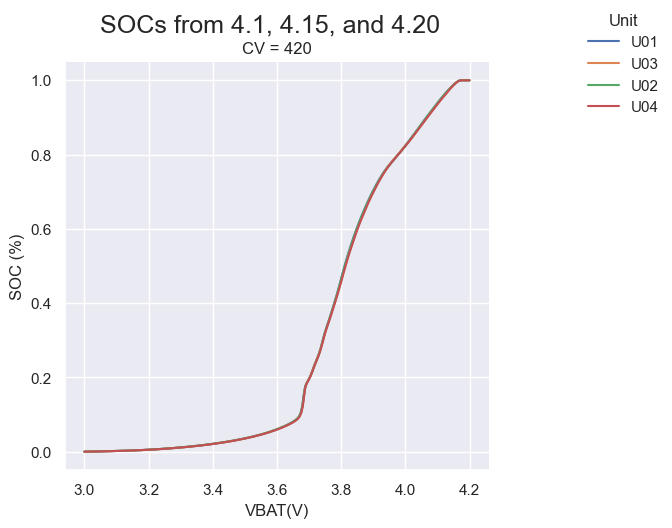

In [33]:
import matplotlib.ticker as mtick
sns.set(rc={"figure.figsize": (8, 4)})
g = sns.FacetGrid(r, col="CV", hue="Unit")
g.map(sns.lineplot, "v", "soc")
g.add_legend(loc='upper right')
g.set_axis_labels("VBAT(V)", "SOC (%)")
g.fig.set_size_inches(8,6)
plt.subplots_adjust(top=0.9)
g.fig.suptitle('SOCs from 4.1, 4.15, and 4.20', fontsize=18)

## Single Graph SOC Overplot

I simply filtered for one unit and plotted all the SOCs on one plot. 

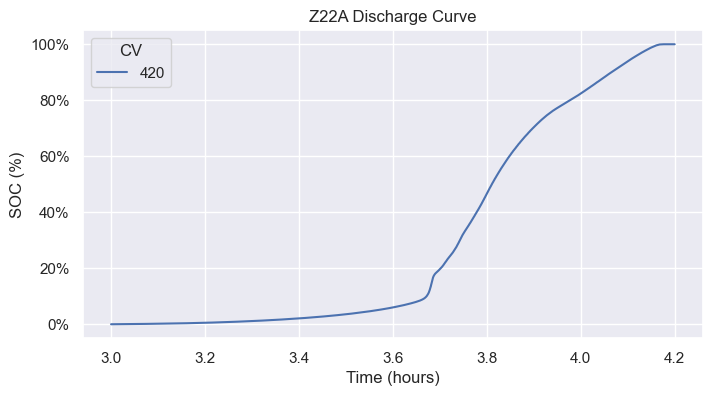

In [34]:
# These are close enough that I don't need to average them. I will just overplot.
r1 = r.query("Unit=='U01'").assign(soc = lambda x: x.soc*100)
g = sns.lineplot(data=r1,x='v', y='soc',hue='CV')
g.yaxis.set_major_formatter(mtick.PercentFormatter())
g.set_title("SOC Overplot")
plt.xlabel("Time (hours)")
plt.ylabel("SOC (%)")
plt.title("Z22A Discharge Curve")
plt.show(fig)

## SOC from 3.414 V to 4.2 V

This is the SOC we would use in our application.

In [35]:
from scipy import interpolate
n = r1[r1['v']>3.414]
y1 = pd.DataFrame()
for u in n.CV.unique():
    x = n[n['CV']==u]
    socmin=x['soc'].min()
    f1 = interpolate.interp1d(x.v, x.t, fill_value='extrapolate')
    g1 = interpolate.interp1d(x.v, x.q, fill_value='extrapolate')
    new_row = pd.DataFrame({'soc':0,'v':3.414, 't':f1(3.414), 'q':g1(3.414),'Unit':'U01',"Model":"Z22A","CV":u}, index=[0])
    x=x.assign(soc = lambda x: (x.soc-socmin)/(100-socmin))
    x=pd.concat([x.loc[:],new_row])
    y1 = y1.append(x).reset_index(drop=True)

C:\Users\Mark\AppData\Local\Temp\ipykernel_200\2506848952.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y1 = y1.append(x).reset_index(drop=True)


C:\Users\Mark\AppData\Local\Temp\ipykernel_200\2769900940.py:2: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  fig = sns.lineplot(


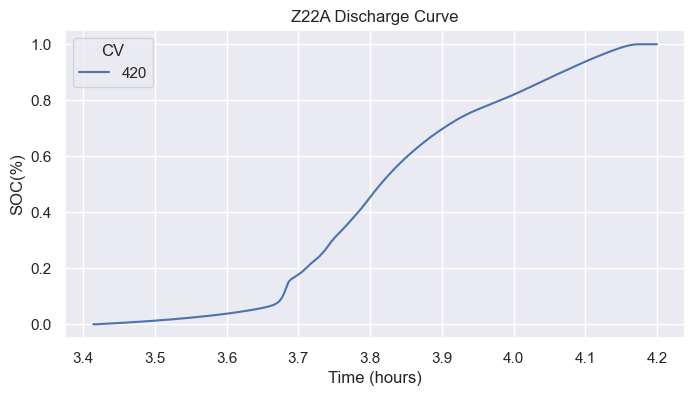

In [36]:
sns.set_style("darkgrid")
fig = sns.lineplot(
            x='v', 
            y='soc',
            hue='CV', 
            palette=['b','r','g'],
            data=y1)
plt.xlabel("Time (hours)")
plt.ylabel("SOC(%)")
plt.title("Z22A Discharge Curve")
plt.show(fig)